# Data Science Challenge
In this exercise, we are going to load a data set on variables that relate to Salaries. We will build a model that can predict salary and identify how different features influence its magnitude.

In [372]:
#Libraries
# https://www.datacamp.com/community/tutorials/categorical-data
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# pd.set_option("display.max_columns", 101)
import warnings
warnings.filterwarnings('ignore')
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

## Data Description

Column | Description
:---|:---
`id` | Record index
`timestamp` | Datetime (YYYY:MM:DD HH:MM:SS)
`country` | Current country of employment
`employment_status` | Employment status (Full time, Part time, Independent or freelancer)
`job_title` | Current job title of the candidate
`job_years` | No. of years working on the job
`is_manager` | Whether the candidate holds a managerial position or not (Yes or No)
`hours_per_week` | No. of hours per day committed to the current job
`telecommute_days_per_week` | No. of telecommuting days per week (working from home)
`education` | Highest degree in education the candidate has received
`is_education_computer_related` | Is the education related to the field of computer science (Yes or No)
`certifications` | Does the candidate have any relevant certifications (Yes or No)
`salary` | Monthly Salary (in US $$)


## Data Wrangling & Visualization

In [373]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [374]:
data.head()

,id,timestamp,country,employment_status,job_title,job_years,is_manager,hours_per_week,telecommute_days_per_week,education,is_education_computer_related,certifications,salary
0,1,12/11/2018 10:52:26,Slovenia,Full time,Developer,4.78393,Yes,40.0,0.0,Bachelors (4 years),Yes,No,7187.743094
1,2,1/5/2017 16:57:50,United States,Full time,DBA,5.00000,No,40.0,5.0,Bachelors (4 years),Yes,No,10000.000000
2,3,12/18/2017 8:13:15,Sweden,Full time,DBA,1.00000,No,40.0,0.0,Masters,Yes,Yes,7000.000000
3,4,12/27/2018 4:56:52,United States,Full time,DBA,1.00000,No,40.0,2.0,Bachelors (4 years),No,No,8333.000000
4,5,12/11/2018 14:07:58,United States,Full time,Developer,3.00000,No,40.0,2.0,Masters,Yes,Yes,7137.000000


Explore columns

In [375]:
data.columns

Index(['id', 'timestamp', 'country', 'employment_status', 'job_title',
       'job_years', 'is_manager', 'hours_per_week',
       'telecommute_days_per_week', 'education',
       'is_education_computer_related', 'certifications', 'salary'],
      dtype='object')

Description

In [376]:
data.describe()

,id,job_years,hours_per_week,telecommute_days_per_week,salary
count,4277.00000,4277.000000,4260.000000,4266.000000,4277.000000
mean,2139.00000,4.479697,40.859110,1.034927,7057.701984
std,1234.80788,1.990783,1.754911,1.651160,1308.572568
min,1.00000,0.000000,37.000000,0.000000,3622.000000
25%,1070.00000,3.407156,40.000000,0.000000,6496.788236
50%,2139.00000,4.640830,40.000000,0.000000,7166.000000
75%,3208.00000,5.000000,41.114138,1.000000,7614.831964
max,4277.00000,10.000000,45.000000,5.000000,10625.000000


Let's remove Timestamp and instead add year variables

In [377]:
data['year']=pd.DatetimeIndex(data['timestamp']).year
data=data.drop(columns=['timestamp'])
data.columns

Index(['id', 'country', 'employment_status', 'job_title', 'job_years',
       'is_manager', 'hours_per_week', 'telecommute_days_per_week',
       'education', 'is_education_computer_related', 'certifications',
       'salary', 'year'],
      dtype='object')

categorical variables value frequencies

In [378]:
data['certifications'].value_counts()

Yes    2185
No     2092
Name: certifications, dtype: int64

In [379]:
data['is_education_computer_related'].value_counts()

Yes        2425
No         1193
Unknown     643
Name: is_education_computer_related, dtype: int64

In [380]:
data['is_manager'].value_counts()

No     3293
Yes     984
Name: is_manager, dtype: int64

In [381]:
data['employment_status'].value_counts()

Full time                                     4088
Independent or freelancer or company owner     170
Part time                                       19
Name: employment_status, dtype: int64

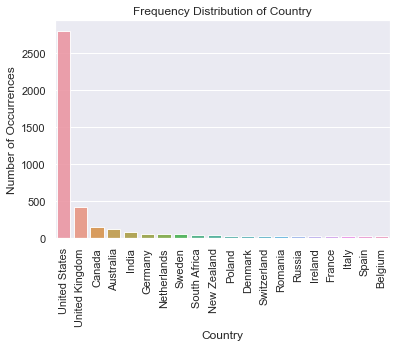

In [382]:
country_count = data['country'].value_counts()
sns.set(style="darkgrid")
sns.barplot(country_count.index[0:20],country_count.values[0:20],alpha=0.9)
plt.title('Frequency Distribution of Country')
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Country', fontsize=12)
pyplot.xticks(rotation=90)
plt.show()

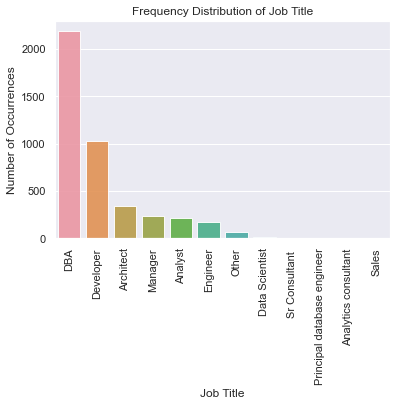

In [383]:
job_title=data['job_title'].value_counts()
sns.set(style="darkgrid")
sns.barplot(job_title.index[0:20],job_title.values[0:20],alpha=0.9)
plt.title('Frequency Distribution of Job Title')
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Job Title', fontsize=12)
pyplot.xticks(rotation=90)
plt.show()

I will transform all categorical variables to dummy variables

In [384]:
country=pd.get_dummies(data['country'],drop_first=True,dummy_na=False).reset_index(drop=True)
country=country.add_prefix('country_')
employment_status=pd.get_dummies(data['employment_status'],drop_first=True,dummy_na=False).reset_index(drop=True)
employment_status=employment_status.add_prefix('employment_status_')
job_title=pd.get_dummies(data['job_title'],drop_first=True,dummy_na=False).reset_index(drop=True)
job_title=job_title.add_prefix('job_title_')
education=pd.get_dummies(data['education'],drop_first=True,dummy_na=False).reset_index(drop=True)
education=education.add_prefix('education_')
is_education_computer_related=pd.get_dummies(data['is_education_computer_related'],dummy_na=False).reset_index(drop=True)
is_education_computer_related=is_education_computer_related.add_prefix('is_education_computer_related_')
certifications=pd.get_dummies(data['certifications'],drop_first=True,dummy_na=False).reset_index(drop=True)
certifications=certifications.add_prefix('certifications_')
is_manager=pd.get_dummies(data['is_manager'],drop_first=True,dummy_na=False).reset_index(drop=True)
is_manager=is_manager.add_prefix('is_manager_')
data.drop(['country','employment_status','job_title','education','is_education_computer_related','certifications','is_manager'],axis=1,inplace=True)
data=pd.concat([data,country,employment_status,job_title,education,is_education_computer_related,certifications,is_manager], axis=1)

## Visualization, Modeling, Machine Learning

Build a model that can predict  salary and identify how different features influence their decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of mean absolute error.**
- **Read the test.csv file and prepare features for testing.**

In [385]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,timestamp,country,employment_status,job_title,job_years,is_manager,hours_per_week,telecommute_days_per_week,education,is_education_computer_related,certifications
0,1,12/13/2018 10:23:29,Ukraine,Full time,Developer,5.0,No,40.0,5,Doctorate/PhD,Yes,Yes
1,2,12/21/2017 3:51:48,United Kingdom,Full time,Developer,10.0,Yes,40.0,1,None (no degree completed),Unknown,No
2,3,12/23/2017 12:31:05,United States,Full time,Developer,3.0,No,40.0,0,Associates (2 years),Yes,Yes
3,4,12/14/2017 22:09:43,Canada,Full time,Analyst,5.0,No,40.0,0,Bachelors (4 years),Yes,No
4,5,1/2/2018 13:29:11,United States,Full time,DBA,5.0,Yes,40.0,0,Bachelors (4 years),Yes,No


Let's extract the year from timestamp, since there might be years where salaries are generally different than others.

In [386]:
test_data['year']=pd.DatetimeIndex(test_data['timestamp']).year
test_data[['timestamp','year']]

,timestamp,year
0,12/13/2018 10:23:29,2018
1,12/21/2017 3:51:48,2017
2,12/23/2017 12:31:05,2017
3,12/14/2017 22:09:43,2017
4,1/2/2018 13:29:11,2018
...,...,...
1065,12/20/2017 8:14:34,2017
1066,12/21/2018 15:46:12,2018
1067,12/12/2017 11:33:04,2017
1068,12/17/2018 8:44:54,2018


We'll drop 'timestamp' from the test data.

In [387]:
test_data=test_data.drop(columns=['timestamp'])
test_data.columns

Index(['id', 'country', 'employment_status', 'job_title', 'job_years',
       'is_manager', 'hours_per_week', 'telecommute_days_per_week',
       'education', 'is_education_computer_related', 'certifications', 'year'],
      dtype='object')

In [388]:
country=pd.get_dummies(test_data['country'],drop_first=True,dummy_na=False).reset_index(drop=True)
country=country.add_prefix('country_')
employment_status=pd.get_dummies(test_data['employment_status'],drop_first=True,dummy_na=False).reset_index(drop=True)
employment_status=employment_status.add_prefix('employment_status_')
job_title=pd.get_dummies(test_data['job_title'],drop_first=True,dummy_na=False).reset_index(drop=True)
job_title=job_title.add_prefix('job_title_')
education=pd.get_dummies(test_data['education'],drop_first=True,dummy_na=False).reset_index(drop=True)
education=education.add_prefix('education_')
is_education_computer_related=pd.get_dummies(test_data['is_education_computer_related'],dummy_na=False).reset_index(drop=True)
is_education_computer_related=is_education_computer_related.add_prefix('is_education_computer_related_')
certifications=pd.get_dummies(test_data['certifications'],drop_first=True,dummy_na=False).reset_index(drop=True)
certifications=certifications.add_prefix('certifications_')
is_manager=pd.get_dummies(test_data['is_manager'],drop_first=True,dummy_na=False).reset_index(drop=True)
is_manager=is_manager.add_prefix('is_manager_')
test_data.drop(['country','employment_status','job_title','education','is_education_computer_related','certifications','is_manager'],axis=1,inplace=True)
test_data=pd.concat([test_data,country,employment_status,job_title,education,is_education_computer_related,certifications,is_manager], axis=1)



**The management wants to know the most important features for the model.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


Let's define a model

In [389]:
# define the model
XGBRmodel = XGBRegressor()

Let's fit the model, note that we drop observations where at least one feature data point is missing

In [390]:
data=data.dropna()
X = data.copy()
X=X.drop(columns=['id','salary'])
y = data["salary"]
X = X.iloc[:,:]
# fit the model
XGBRmodel.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Let's visualize the top 20 features and their feature importance, ordered from most to least important.

Feature: 0, Score: 0.15242
Feature: 1, Score: 0.02853
Feature: 2, Score: 0.02641
Feature: 3, Score: 0.02320
Feature: 4, Score: 0.02247
Feature: 5, Score: 0.02229
Feature: 6, Score: 0.02221
Feature: 7, Score: 0.02187
Feature: 8, Score: 0.02158
Feature: 9, Score: 0.02109
Feature: 10, Score: 0.02047
Feature: 11, Score: 0.02042
Feature: 12, Score: 0.01973
Feature: 13, Score: 0.01968
Feature: 14, Score: 0.01915
Feature: 15, Score: 0.01797
Feature: 16, Score: 0.01796
Feature: 17, Score: 0.01787
Feature: 18, Score: 0.01773
Feature: 19, Score: 0.01743


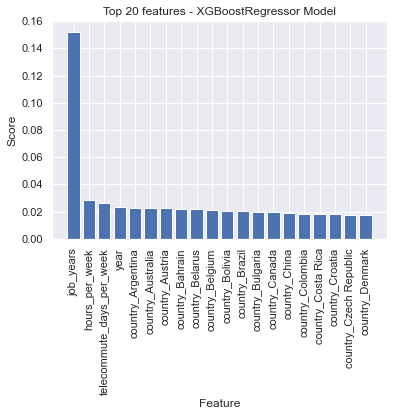

In [391]:
# get importance
importance=XGBRmodel.feature_importances_
importance=np.sort(importance)[::-1]
importance_idxs=np.argsort(importance)[::-1]
X = data.copy()
X=X.drop(columns=['id','salary'])
features=[X.columns[i] for i in importance_idxs]
# summarize feature importance
for i,v in enumerate(importance[0:20]):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([features[x] for x in range(len(importance[0:20]))],importance[0:20])
pyplot.xticks(rotation=90)
pyplot.ylabel('Score')
pyplot.xlabel('Feature')
pyplot.title('Top 20 features - XGBoostRegressor Model')
pyplot.show()
X_train=X.copy()

XGBoostRegressor Mean Absolute Error

In [392]:
y_train=XGBRmodel.predict(X)
print(mean_absolute_error(y,y_train))

477.3737724558536


Let us do the similar analysis changing the model to a Linear Regression model.

In [393]:
# define the model
LRmodel=LinearRegression()
data=data.dropna()
X = data.copy()
X=X.drop(columns=['id','salary'])
y = data["salary"]
X = X.iloc[:,:]
# fit the model
LRmodel.fit(X, y)

LinearRegression()

Let's look at feature importance in this model

Feature: 0, Score: 3428.98555
Feature: 1, Score: 3313.47869
Feature: 2, Score: 2822.72211
Feature: 3, Score: 2082.10911
Feature: 4, Score: 1768.02854
Feature: 5, Score: 1533.88931
Feature: 6, Score: 1521.17109
Feature: 7, Score: 1511.48363
Feature: 8, Score: 1468.96671
Feature: 9, Score: 1369.73057
Feature: 10, Score: 1253.26906
Feature: 11, Score: 1191.91939
Feature: 12, Score: 1047.31342
Feature: 13, Score: 1046.11861
Feature: 14, Score: 1030.28218
Feature: 15, Score: 1011.21778
Feature: 16, Score: 1008.74071
Feature: 17, Score: 991.20431
Feature: 18, Score: 967.02984
Feature: 19, Score: 956.59177


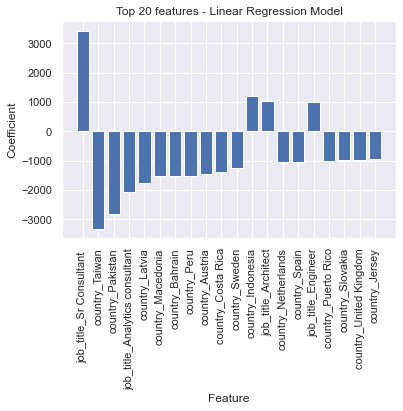

In [394]:
# get importance
coefficients=LRmodel.coef_
importance=np.sort(abs(coefficients))[::-1]
importance_idxs=np.argsort(abs(coefficients))[::-1]
X = data.copy()
X=X.drop(columns=['id','salary'])
features=[X.columns[i] for i in importance_idxs]
coefficients=[coefficients[i] for i in importance_idxs]
# coefficients
# summarize feature importance
for i,v in enumerate(importance[0:20]):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([features[x] for x in range(len(importance[0:20]))],coefficients[0:20])
pyplot.xticks(rotation=90)
pyplot.ylabel('Coefficient')
pyplot.xlabel('Feature')
pyplot.title('Top 20 features - Linear Regression Model')
pyplot.show()

The first thing that we note is that feature importace is remarkably different using the XGBoostRegressor Model or the Linear Regression Model. 
Second, with the Linear Regression Model we can have a linear interpretation of the coefficients:
in the model, Senior Consultants receive higher than average annual salaries (above USD 3,000 monthly). Architects and Engineers also have higher than average monthly salaries.
Countries like Taiwan and Pakistan have a negative effect on salaries.

Linear Regression Mean Absolute Error

In [395]:
y_train=LRmodel.predict(X)
print(mean_absolute_error(y,y_train))

847.0373471764875


Mean absolute error is lower for the XGBoostRegressor Model in the train data. Based on this metric, we shall discriminate the two models in favour of he XGBoostRegressor Model.

> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `salary` variable. Submit a CSV file with a header row and one row per test entry. 

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **salary**

In [396]:
# out-of-sample prediction:
# test_data=test_data.dropna()
X = test_data.copy()
X=X.drop(columns=['id'])
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X = X[X_train.columns]
y_test=XGBRmodel.predict(X)

In [405]:
test_data['salary']=y_test
submission_df=test_data[['id','salary']]
# submission_df.head()
submission_df.head()

,id,salary
0,1,6784.928223
1,2,6364.805176
2,3,6728.322754
3,4,6128.474121
4,5,7137.573730


In [406]:
#Submission
submission_df.to_csv('submission.csv',index=False)

---